# Block Puzzleの自動計算

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import pulp
import time
import math
import random
import itertools

## 1. ブロックとボードの定義

/var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/ipykernel_49782/288018573.py:57: UserWarning: Glyph 20984 (\N{CJK UNIFIED IDEOGRAPH-51F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/ipykernel_49782/288018573.py:57: UserWarning: Glyph 20985 (\N{CJK UNIFIED IDEOGRAPH-51F9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/matsuda/Documents/Private/PythonSandbox/block_puzzle_sovler/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20984 (\N{CJK UNIFIED IDEOGRAPH-51F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matsuda/Documents/Private/PythonSandbox/block_puzzle_sovler/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20985 (\N{CJK UNIFIED IDEOGRAPH-51F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


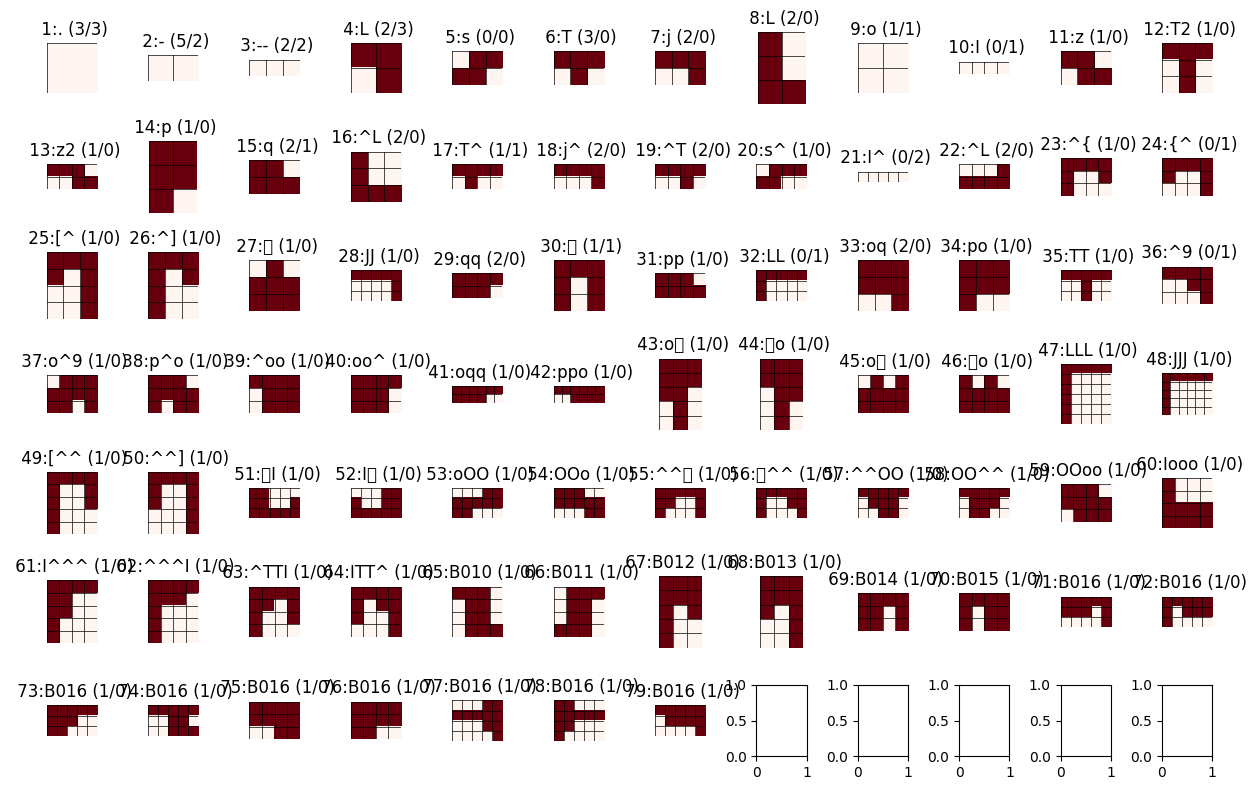

In [2]:
def load_blocks_from_csv(filename):
    names = []
    blocks = []
    normal_quantities = []
    priority_quantities = []
    
    df = pd.read_csv(filename)
    
    for idx, row in df.iterrows():
                
        # 座標文字列をパース
        name = row['name']
        if name.startswith("#"):
            continue
        coord_str = row['coordinates']
        coords = [tuple(map(int, coord.strip('()').split(','))) 
                 for coord in coord_str.split('),')]

        # 座標から形状を復元
        max_row = max(c[0] for c in coords) + 1
        max_col = max(c[1] for c in coords) + 1
        
        # ブロックの形状を表す2D配列を作成
        shape = np.zeros((max_row, max_col), dtype=int)
        for r, c in coords:
            shape[r, c] = 1

        names.append(name)
        blocks.append(shape)
        normal_quantities.append(int(row['normal_quantity']))
        priority_quantities.append(int(row['priority_quantity'])) # 1を優先、２を通常

    return blocks, normal_quantities, priority_quantities, names

blocks, normal_quantities, priority_quantities,names = load_blocks_from_csv('blocks.csv')

# ブロックの集計
piece_count = [sum(v.flatten()) for v in blocks]
max_pieces = max(piece_count)

# ブロックの可視化
col_size = min(12, len(blocks))
row_size = (len(blocks) + col_size - 1) // col_size
fig, axs = plt.subplots(row_size, col_size, figsize=(12, 8))
if row_size == 1:
    axs = [axs]
for i, block in enumerate(blocks):
    current_axs = axs[i//col_size][i%col_size]
    current_axs.imshow(block, cmap='Reds')
    current_axs.grid(True, color='black', linestyle='-', linewidth=0.5)
    for x in range(block.shape[1]):
        current_axs.axvline(x - 0.5, color='black', linewidth=0.5)
    for y in range(block.shape[0]):
        current_axs.axhline(y - 0.5, color='black', linewidth=0.5)
    current_axs.set_title(f' {i+1}:{names[i]} ({normal_quantities[i]}/{priority_quantities[i]})')
    current_axs.axis('off')
plt.tight_layout()
plt.show()

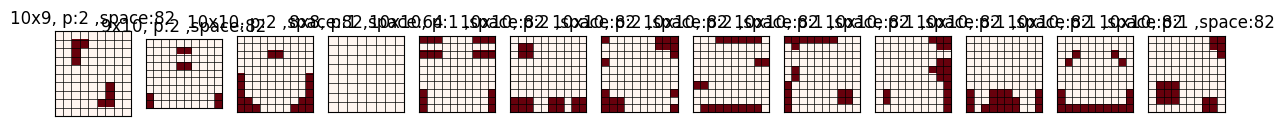

In [3]:
def load_boards_from_csv(filename):
    boards = []
    board_priorities = []
    
    df = pd.read_csv(filename)
    
    for idx, row in df.iterrows():
        if str(row['rows']).startswith("#"):
            continue
        rows = int(row['rows'])
        cols = int(row['cols'])

        # 座標文字列をパース
        walls_str = row['walls']
        if isinstance(walls_str, float) and math.isnan(walls_str):
            walls = []  # 壁がない場合は空リスト
        else:
            walls = [tuple(map(int, wall.strip('()').split(','))) 
                     for wall in walls_str.split('),')]

        # ボードの形状を表す2D配列を作成
        shape = np.zeros((rows, cols), dtype=int)
        for r, c in walls:
            shape[r, c] = 1

        boards.append(shape)
        board_priorities.append(int(row['priority']))

    return boards, board_priorities

boards, board_priorities = load_boards_from_csv('boards.csv')

# ブロックの可視化
fig, axs = plt.subplots(1, len(boards), figsize=(12, 4))
if len(boards) == 1:
    axs = [axs]
for i, board in enumerate(boards):
    axs[i].imshow(board, cmap='Reds')
    space = board.shape[0]*board.shape[1]-sum(board.flatten())
    axs[i].set_title(f'{board.shape[0]}x{board.shape[1]}, p:{board_priorities[i]} ,space:{space}')
    axs[i].grid(True, color='black', linestyle='-', linewidth=0.5)
    for x in range(board.shape[1]):
        axs[i].axvline(x - 0.5, color='black', linewidth=0.5)
    for y in range(board.shape[0]):
        axs[i].axhline(y - 0.5, color='black', linewidth=0.5)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()

## 2. ブロックの回転

/var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/ipykernel_49782/2907961388.py:32: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/ipykernel_49782/2907961388.py:32: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/matsuda/Documents/Private/PythonSandbox/block_puzzle_sovler/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matsuda/Documents/Private/PythonSandbox/block_puzzle_sovler/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


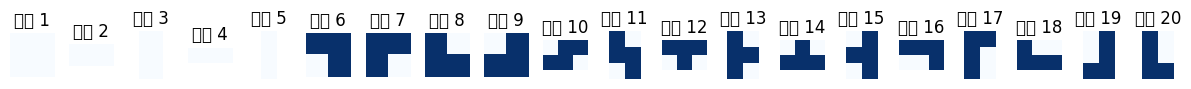

In [4]:
def get_all_orientations(block):
    """ブロックのすべての可能な向き（回転と反転）を生成"""
    orientations = []
    current = block.copy()
    
    # 4つの回転を試す
    for _ in range(4):
        # 現在の向きが既にリストになければ追加
        if not any(np.array_equal(current, x) for x in orientations):
            orientations.append(current.copy())
                
        # 90度回転して次へ
        current = np.rot90(current)
    
    return orientations

# 各ブロックのすべての向きを計算
all_orientations = {}
for idx, block in enumerate(blocks):
    all_orientations[idx] = get_all_orientations(block)
    orientations_count = len(all_orientations[idx])
    #print(f"ブロック {idx+1}: {orientations_count}種類の向き")

# 各ブロックのすべての向きを可視化
all_block_orientations = list(itertools.chain.from_iterable(all_orientations.values()))
fig, axs = plt.subplots(1, len(all_block_orientations[:20]), figsize=(12, 1))
for i, orientation in enumerate(all_block_orientations[:20]):
    axs[i].imshow(orientation, cmap='Blues')
    axs[i].set_title(f'向き {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## 3. 可能な配置の生成

生成された配置の総数: 122294


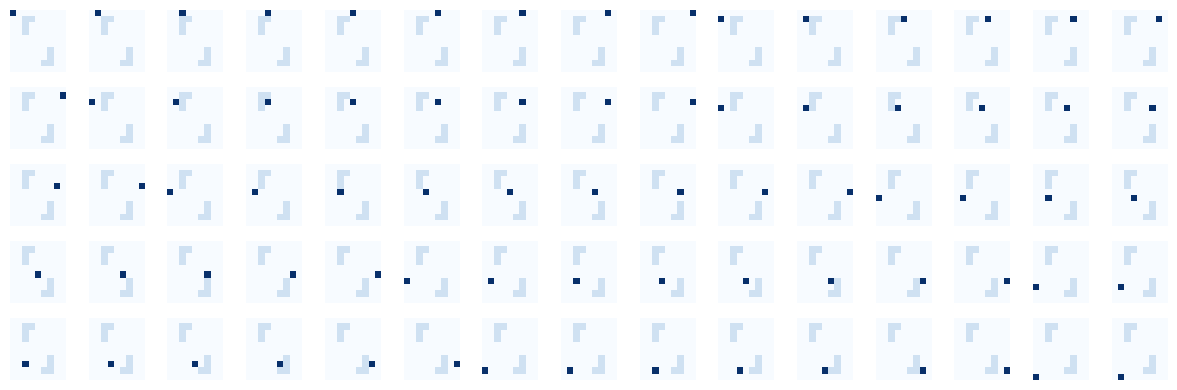

In [5]:
def is_valid_placement(board, block, row, col):
    """指定した位置にブロックを配置できるかチェック"""
    board_rows, board_cols = board.shape
    block_rows, block_cols = block.shape
    
    # ボードの範囲外をチェック
    if row + block_rows > board_rows or col + block_cols > board_cols:
        return False

    for r in range(block_rows):
        for c in range(block_cols):
            if block[r, c] == 1 and board[r+row,c+col] == 1:
                return False
    return True

def get_covered_cells(block, row, col):
    """ブロックが特定の位置で覆うセルの座標リストを返す"""
    covered = []
    block_rows, block_cols = block.shape
    
    for r in range(block_rows):
        for c in range(block_cols):
            if block[r, c] == 1:
                covered.append((row + r, col + c))
    
    return covered

# すべての可能な配置を生成
all_placements = []

for block_idx, orientations in all_orientations.items():
    for orientation_idx, orientation in enumerate(orientations):
        for board_idx, board in enumerate(boards):
            for row in range(board.shape[0]):
                for col in range(board.shape[1]):
                    if is_valid_placement(board, orientation, row, col):
                        # この配置が覆うセルを取得
                        covered_cells = get_covered_cells(orientation, row, col)
                        
                        # 配置情報を保存
                        placement = {
                            'board_idx': board_idx,
                            'block_idx': block_idx,
                            'orientation_idx': orientation_idx,
                            'position': (row, col),
                            'covered_cells': covered_cells
                        }
                        
                        all_placements.append(placement)

print(f"生成された配置の総数: {len(all_placements)}")

# 各ブロックの配置を可視化
row_size = 5
col_size = 15
fig, axs = plt.subplots(row_size, col_size, figsize=(12, 4))
for i in range( 0, row_size ):
    for j in range( 0, col_size ):
        placement = all_placements[i*col_size+j]
        board = boards[placement['board_idx']].copy()
        block_idx = placement['block_idx']
        orientation_idx = placement['orientation_idx']
        row, col = placement['position']
        
        orientation = all_orientations[block_idx][orientation_idx]
        block_rows, block_cols = orientation.shape
        
        for r in range(block_rows):
            for c in range(block_cols):
                if orientation[r, c] == 1:
                    board[row + r, col + c] = 5

        axs[i][j].imshow(board, cmap='Blues')
        axs[i][j].set_axis_off()

plt.tight_layout()
plt.show()


## 4. PuLPを使った線形計画問題の設定

In [ ]:
# 全ボード同時計算は処理時間がかかるため１ボードずつ処理
def build_problem(board_idx):
    board = boards[board_idx]

    # 問題の定義
    prob = pulp.LpProblem(f"MultiBoard_BlockPuzzle_{board_idx}", pulp.LpMaximize)
    
    # 変数の定義
    
    # 1. 配置変数: 各ボードの各配置を使用するかどうか(0または1)
    placement_vars = {}
    for placement_idx, placement in enumerate(all_placements):
        if board_idx != placement['board_idx']:
            continue
        block_idx = placement['block_idx']
        placement_vars.setdefault(block_idx, [])
        qty = normal_quantities[block_idx]
        if qty > 0 :
            var_name = f"x_{board_idx}_{placement_idx}_{block_idx}" # 2: placement_idx
            placement_vars[block_idx].append( pulp.LpVariable(var_name, 0, 1, pulp.LpInteger))

    # 2. ボード完全充填変数: ボードがすべて埋まっているかどうか(0または1)
    var_name = f"filled_{board_idx}"
    board_filled = pulp.LpVariable(var_name, 0, 1, pulp.LpInteger)
    
    # 3. ブロック使用変数: 各ブロックインスタンスが使用されているかどうか
    block_used = {}
    for block_idx, block in enumerate(blocks):
        qty = normal_quantities[block_idx]
        var_name = f"used_{block_idx}"
        block_used[block_idx] = pulp.LpVariable(var_name, 0, qty, pulp.LpInteger)


    # 目的関数: 優先度を考慮した複合目標
    # 1. 埋まったボードの数を最大化（最重要）
    # 2. 優先度の高いブロックを優先
    # 3. ブロックのピース数が多いものを優先
    
    # 大きな重みの設定（階層的に優先順位を強制）
    board_fill_weight = 1000000  # ボード充填の重み
    block_weight = 10  # ブロックの重み
    
    max_board_fill_score = board_fill_weight
    max_block_score = ((block_weight * max_pieces)**2) * sum(normal_quantities)

    total_max_score = max_board_fill_score + max_block_score
    prob += (
        total_max_score - 
        # 1. 埋まったボードの数
        board_fill_weight * (1-board_filled) - 
        # 2. 使ったブロック（低いほど良い = マイナスで加算）
        pulp.lpSum(((block_weight * np.log(piece_count[i]))**2) * (normal_quantities[i]-block_used[i])
                                                         for i in range(len(block_used)))
    )

    # 制約条件
    # 1. 各ブロックインスタンスは所有数使用される
    for block_idx, block in enumerate(blocks):
        # このブロックインスタンスの使用合計 == block_used変数
        prob += pulp.lpSum(placement_vars[block_idx]) == block_used[block_idx], f"block_{block_idx}_used_total"
        prob += block_used[block_idx] <= normal_quantities[block_idx], f"block_{block_idx}_used_once"
    
    # 2. 各ボードの各セルは最大1つのブロックで覆われる
    covering_placements = {}
    for idx, block_vars in placement_vars.items():
        for i, var in enumerate(block_vars):
            var_name = var.name.split('_')
            placement = all_placements[int(var_name[2])]
            for cell in placement['covered_cells']:
                covering_placements.setdefault(cell, [])
                covering_placements[cell].append(var)

    for j, vars in covering_placements.items():
        prob += pulp.lpSum(vars) <= 1, f"Cell_{board_idx}_{idx}_{var.name}_{j}_covered_once"

    
    # 3. ボードが完全に埋まる条件
    rows, cols = board.shape
    total_cells = rows * cols - sum(board.flatten())

    # 埋められたセルの総数
    covered_cells = pulp.lpSum(sum(blocks[b].flatten()) * placement_vars[b] 
                        for b in range(len(blocks)))

    # 「ボードが完全に埋まっている」の定義
    # 1) board_filled[board_idx] = 1 なら、全セルが埋まっている
    # 2) 全セルが埋まっていなければ board_filled[board_idx] = 0
    
    # Big-M法を使用して論理関係を表現
    M = total_cells + 1  # 十分大きな数
    
    # board_filled = 1 → covered_cells = total_cells
    prob += covered_cells <= total_cells, f"Board_{board_idx}_filled"
    prob += covered_cells >= total_cells - M * (1 - board_filled), f"Board_{board_idx}_filled_implies_all_covered"
    
    # covered_cells = total_cells → board_filled = 1
    prob += covered_cells <= total_cells - 1 + M * board_filled, f"Board_{board_idx}_all_covered_implies_filled"

    #print( f"objective func:{prob}")

    return prob, placement_vars

# 問題を解く
placement_vars = {}
for board_idx, board in enumerate(boards):
    print(f"Board {board_idx} 最適化問題を解いています...")
    start_time = time.time()

    prob, vars = build_problem(board_idx)
    placement_vars.setdefault(board_idx, {})
    placement_vars[board_idx] = vars

    solver = pulp.PULP_CBC_CMD(msg=True)
    solver.timeLimit = 180       # 180秒の時間制限
    solver.gapRel = 0.05        # 5%のギャップで解を許容
    solver.threads = 4          # 4スレッドで実行（マルチコア使用）
    prob.solve(solver)
    
    if pulp.LpStatus[prob.status] == 'Optimal':
        for idx, block_vars in vars.items():
            for i, var in enumerate(block_vars):
                var_name = var.name.split('_')
                placement = all_placements[int(var_name[2])]
                if pulp.value(var) == 1:
                    normal_quantities[placement['block_idx']] -= 1
    end_time = time.time()
    
    print(f"ステータス: {pulp.LpStatus[prob.status]}")
    print(f"実行時間: {end_time - start_time:.2f}秒")

Board 0 最適化問題を解いています...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/matsuda/Documents/Private/PythonSandbox/block_puzzle_sovler/myenv/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/72d39260ba03458c866d06dd1effdd65-pulp.mps -max -sec 180 -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/l47n12z91gscsn0r8q2p50pc0000gq/T/72d39260ba03458c866d06dd1effdd65-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 248 COLUMNS
At line 92970 RHS
At line 93214 BOUNDS
At line 100266 ENDATA
Problem MODEL has 243 rows, 7051 columns and 78540 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 180
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.00444e+06 - 0.05 seconds
Cgl0004I processed model has 157 rows, 7044 columns (7044 integer (7031 of which binary)) and 71482 elements
Cbc003

In [ ]:
## 5. 解の可視化

In [ ]:
def visualize_solution(board_idx, all_placements, all_orientations, placement_vars, axs):
    """解を可視化"""
    board = boards[board_idx]

    # 使用されるブロックの数をカウント
    used_blocks = 0
    
    # 解のボードを作成
    solution_board = board.copy()*-1
    #solution_board = np.zeros((board.shape[0], board.shape[1]), dtype=int)

    # 選ばれた配置をボードに適用
    for i, block_vars in placement_vars.items():
        for j, var in enumerate(block_vars):
            var_name = var.name.split('_')
            placement = all_placements[int(var_name[2])]
            if board_idx != placement['board_idx']:
                continue

            if pulp.value(var) == 1:  # この配置が選ばれた
                block_idx = placement['block_idx']
                orientation_idx = placement['orientation_idx']
                row, col = placement['position']

                orientation = all_orientations[block_idx][orientation_idx]
                block_rows, block_cols = orientation.shape
                used_blocks += 1
                
                # ブロックをボードに配置（ブロック名に対応する値を設定）
                for r in range(block_rows):
                    for c in range(block_cols):
                        if orientation[r, c] == 1:
                            solution_board[row + r, col + c] = block_idx+1

    colors = []
    for i in range(used_blocks):
        h = random.random()  # 0～1のランダムな色相
        s = 0.7 + random.random() * 0.3  # 0.7～1.0の彩度
        v = 0.7 + random.random() * 0.3  # 0.7～1.0の明度
        r, g, b = plt.cm.hsv(h)[:3]
        colors.append((r, g, b))

    cmap = ListedColormap(colors)

    axs.set_title(f"Board {board_idx} / ({used_blocks} used)")
    axs.imshow(solution_board, cmap=cmap, interpolation='nearest')
    axs.grid(True, color='black', linestyle='-', linewidth=0.5)

    
    rows, cols = solution_board.shape
    for i in range(rows):
        for j in range(cols):
            value = solution_board[i, j]
            if value > 0:
                axs.text(j, i, int(value), ha='center', va='center', color='black')
    
    axs.set_xticks(np.arange(-0.5, cols, 1), [])
    axs.set_yticks(np.arange(-0.5, rows, 1), [])
        
    return used_blocks, solution_board

# 解が見つかった場合は可視化
if pulp.LpStatus[prob.status] == 'Optimal':
    col_size = 2
    row_size = (len(boards) + col_size - 1) // col_size
    fig, axs = plt.subplots(row_size, col_size, figsize=(20, 20))
    if row_size == 1:
        axs = [axs]
    for board_idx, board in enumerate(boards):
        current_axs = axs[board_idx//col_size][board_idx%col_size]
        used_blocks, solution_board = visualize_solution(board_idx, all_placements, all_orientations, placement_vars[board_idx], current_axs )
        
        # 使用されたブロックごとの詳細を表示
        print(f"\nBoard {board_idx} 使用されたブロック:")
        cnt = 0
        for i, block_vars in placement_vars[board_idx].items():

            for j, var in enumerate(block_vars):
                var_name = var.name.split('_')
                placement = all_placements[int(var_name[2])]
                if board_idx != placement['board_idx']:
                    continue
                if pulp.value(var) == 1:
                    block_name = placement['block_idx']
                    row, col = placement['position']
                    print(f"ブロック {block_name+1}: 位置 ({row}, {col})")
                    cnt += 1
            
    plt.tight_layout()
    plt.show()
else:
    print("\n解が見つかりませんでした。他のブロックの組み合わせを試してください。")